# Make plots for GAM predictions generated in R

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from settings_general import channel_name_dict
from shared.helper_functions import select_folder, save_figure

Change plot theme

In [2]:
sns.set_theme()

Define palette

In [3]:
palette = {'DRD2-WT': '#419D78', 'DRD2-KO': '#EB5E55'}

### Function definition

In [4]:
def parse_summary_significance(text_filepath, header_line = 'freqs window(s) of significant difference(s):\n', end_line = "Summary:\n"):
    """
        Parser for getting significance windows from model report
    """
    
    with open(text_filepath, "r") as f:
        summary = f.readlines()

    # Find header line index
    try:  # if there is no header line, then there are no significant differences
        header_idx = summary.index(header_line)
    except ValueError:
        return pd.DataFrame({})
    
    # find line to stop at
    count = 0
    end_idx = None

    # there are two 'Summary:\n' occurrences, let's find the second
    for i, item in enumerate(summary):
        # Check if the current item is equal to end_line
        if item == end_line:
            # Increment the count of occurrences
            count += 1
            # If it's the second occurrence, store its index and break the loop
            if count == 2:
                end_idx = i
                break

    # Extract the lines containing session_bin windows
    freq_lines = summary[header_idx + 1:end_idx]

    # Extract the numbers from the lines
    numbers = [re.findall(r'([\d.]+)', line) for line in freq_lines]
    return pd.DataFrame(numbers, columns=['from_freq', 'to_freq']).apply(pd.to_numeric)

### Loop model results and plot modeled data

In [43]:
model_results_path = select_folder("Select the folder holding the GAM model output files (summaries & predictions) for this experiment")

In [41]:
plots_folder = select_folder("Select the folder you wish to save plots to")

In [42]:
model_results_path

'C:/Users/Olle de Jong/Documents/MSc Biology/rp2/rp2_data/3C_sociability/output/plots/one_sec_no_overlap/GAMs/GAMs/MIM'

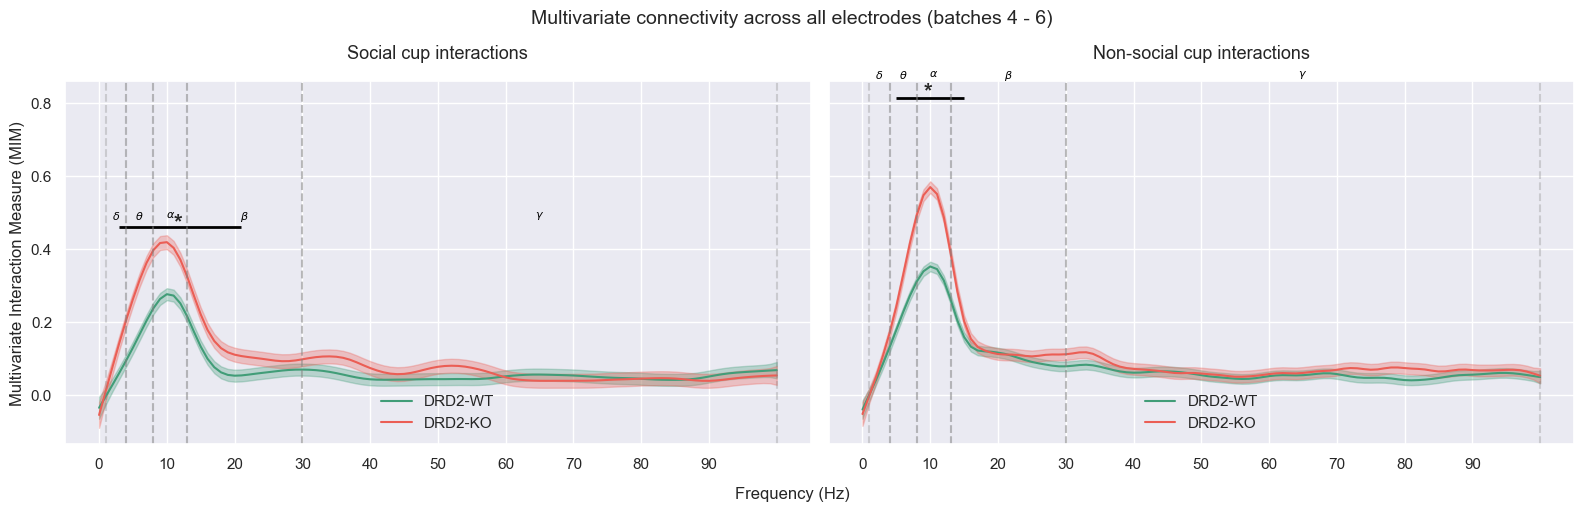

In [45]:
from settings_general import freq_bands_eeg

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True, sharex=True)
axs = axs.ravel()

# ADD NON-SOCIAL CUP AXIS

pred_path = f"{model_results_path}/pred_3_chamber_sociability_social_cup.xlsx"
summary_path = f"{model_results_path}/summary_3_chamber_sociability_social_cup.txt"

df = pd.read_excel(pred_path)
sig_win = parse_summary_significance(summary_path)

genotype = df['genotype'].unique()
    
# loop through genotypes
for i, genotype in enumerate(genotype):
    # get the genotype data
    df_sub = df[df['genotype'] == genotype]
    # plot the line
    axs[0].plot(df_sub['freqs'], df_sub['fit'], color=palette[genotype], label=genotype)
    axs[0].fill_between(df_sub['freqs'], df_sub['fit'] + df_sub['CI'], df_sub['fit'] - df_sub['CI'], color=palette[genotype], alpha=0.3)

axs[0].set_xticks(np.arange(0, 100, 10))
axs[1].set_xlabel(None)
axs[0].set_ylabel('Multivariate Interaction Measure (MIM)', x=1.2)
axs[0].set_title('Social cup interactions', fontsize=13, y=1.04)
axs[0].legend(loc='best', frameon=False)

ymin = axs[0].get_ylim()[0]
ymax = df_sub['fit'].max() + 0.1 * df_sub['fit'].max()
for window in sig_win.itertuples():
    axs[0].text(np.floor((window.from_freq + window.to_freq) / 2.0001), ymax * 0.99, '*', fontweight='bold', fontsize=16)
    axs[0].hlines(ymax, xmin=window.from_freq, xmax=window.to_freq, color='black', linewidth=2)
    
for band, (start, end) in freq_bands_eeg.items():
    axs[0].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axs[0].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 1.04, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    
# ADD SOCIAL CUP AXIS

pred_path = f"{model_results_path}/pred_3_chamber_sociability_non-social_cup.xlsx"
summary_path = f"{model_results_path}/summary_3_chamber_sociability_non-social_cup.txt"

df = pd.read_excel(pred_path)
sig_win = parse_summary_significance(summary_path)

genotype = df['genotype'].unique()
    
# loop through genotypes
for i, genotype in enumerate(genotype):
    # get the genotype data
    df_sub = df[df['genotype'] == genotype]
    # plot the line
    axs[1].plot(df_sub['freqs'], df_sub['fit'], color=palette[genotype], label=genotype)
    axs[1].fill_between(df_sub['freqs'], df_sub['fit'] + df_sub['CI'], df_sub['fit'] - df_sub['CI'], color=palette[genotype], alpha=0.3)

axs[1].set_xticks(np.arange(0, 100, 10))
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)
axs[1].set_title('Non-social cup interactions', fontsize=13, y=1.04)
axs[1].legend(loc='best', frameon=False)

ymin = axs[1].get_ylim()[0]
ymax = df_sub['fit'].max() + 0.1 * df_sub['fit'].max()
for window in sig_win.itertuples():
    axs[1].text(np.floor((window.from_freq + window.to_freq) / 2.0001), ymax * 1.3, '*', fontweight='bold', fontsize=16)
    axs[1].hlines(ymax * 1.3, xmin=window.from_freq, xmax=window.to_freq, color='black', linewidth=2)
    
for band, (start, end) in freq_bands_eeg.items():
    axs[1].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axs[1].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 1.04, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, -0.01, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
plt.suptitle('Multivariate connectivity across all electrodes (batches 4 - 6)', fontsize=14, y=0.96)
plt.tight_layout()
save_figure(os.path.join(plots_folder, "gam_plot_dmn_electrodes_batches4-6_combined.pdf"))